In [2]:
# Các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
import warnings
import sklearn

# Các hàm, lớp cần thiết
from tqdm import tqdm
from typing import List, Tuple, Callable
from functools import partial
from concurrent.futures import ProcessPoolExecutor, as_completed
from cmaes import CMA
from sklearn.cluster import KMeans

# Các file đặt cùng thư mục
from DataFrame import fitness_wrapper, gnbg_instances, df_problems
from CECData import cec_wrap
from SingleHerd import run_single_population

# Tắt các cảnh báo không cần thiết
warnings.filterwarnings("ignore")

### Phát biểu bài toán

Trên hình hộp $\mathbb{B}=[a,b]^D$ với $D$ là số chiều không gian, mục tiêu là cực tiểu hóa hàm số $f: \mathbb{B} \to \mathbb{R}$ tức là giải bài toán tối ưu ràng buộc hộp sau:
\begin{align*}
\min_{\mathbf{x}\in \mathbb{B}} f(\mathbf{x})
\end{align*}

- Mỗi vector $\mathbf{x}\in \mathbb{B}$ là một lời giải ứng viên, biểu diễn bằng một cá thể.
- Tập hợp một số lời giải ứng viên là quần thể, có tất cả $P$ quần thể $\mathcal{P}_1,\mathcal{P}_2,\ldots,\mathcal{P}_{P}$.
  - Cá thể tốt nhất trong quần thể $i$ ký hiệu là $\text{best}_i = \min_{\mathbf{x}\in \mathcal{P}_i} f(\mathbf{x})$.
- Tập hợp một số quần thể gọi là quần xã, có tất cả $C$ quần xã $\mathcal{C}_1,\mathcal{C}_2,\ldots,\mathcal{C}_{C}$.

---

### Communication V1: Run to centroid

1. Lấy ra lời giải tốt nhất của tất cả quần thể là $\text{BEST}=\{\text{best}_i: i=1,2,\ldots,P\}$.
2. Dựa trên $\text{BEST}$, sử dụng thuật toán KMeans chia thành $C$ cụm.
3. Với mỗi $i = 1,2,\ldots,C$, xét quần xã $\mathcal{C}_i$.
   - Trọng tâm của cụm $\mathcal{C}_i$, kí hiệu $\text{centroid}_i$ biết được từ kết quả thuật toán KMeans, một cách cụ thể:
\begin{align*}
\text{centroid}_i = \frac{1}{|\mathcal{C}_i|}\sum_{\mathcal{P}_j\in\mathcal{C}_i} \text{best}_j
\end{align*}
   - Mỗi cá thể $\text{best}_j$ xác định một đại lượng vận tốc $v_i$ dựa trên độ tốt của cá thể đó, cụ thể:
\begin{align*}
0\leq v_j = \frac{f(\text{best}_j) - \min_{\mathcal{P_k}\in\mathcal{C}_i} f(\text{best}_k)}{\max_{\mathcal{P_k}\in\mathcal{C}_i} f(\text{best}_k) - \min_{\mathcal{P_k}\in\mathcal{C}_i} f(\text{best}_k)} \leq 1
\end{align*}
   - Đối với mỗi $j$ mà $\mathcal{P}_j\in\mathcal{C}_i$, cập nhật vị trí trung bình mới cho bộ tối ưu ứng với quần thể $j$ như sau:
\begin{align*}
\text{new}_j = \text{old}_j + v_j \times (\text{center}_i - \text{old}_j)
\end{align*}

In [4]:
# COMMUNICATION V1: Tiến về trọng tâm cụm
def communication_v1(
    population_solutions: List[Tuple[np.ndarray, float]],
    optimizers: List[CMA],
    n_population = 10,
    n_dimension = 30,
    bounds = np.array([[-100, 100]]*30)
) -> List[CMA]:
    
    n_communities = int(n_dimension / n_population)

    # 1. Lấy ra các vector lời giải tốt nhất của các quần thể
    best_solutions = [s[0] for s in population_solutions]

    # 2. Trước khi chia nhóm (để tránh các vector lời giải tốt nhất trùng nhau), thêm nhiễu Gaussian vào các vector lời giải tốt nhất
    best_solutions = [s + np.random.normal(0, 0.1, n_dimension) for s in best_solutions]

    # 3. Chia các vector lời giải tốt nhất thành n_clusters cụm
    kmeans = KMeans(n_clusters=n_communities)
    kmeans.fit(best_solutions)

    # 4. Trong mỗi cụm, cập nhật thông tin các đàn
    '''
    - Các vector lời giải tốt nhất tiến về trọng tâm (centroid) của cụm
    - Công thức: new_mean = old_mean + velocity * (centroid - old_mean)
    - Trong đó: velocity = (value - min_vals) / (max_vals - min_vals)
    với max_vals, min_vals là giá trị lớn nhất và nhỏ nhất trong các giá trị hàm fitness các vector trong cụm
    '''

    # Lặp qua các cụm
    for community in range(n_communities):
        # Lấy ra các đàn thuộc cụm này
        members = [i for i in range(len(population_solutions)) if kmeans.labels_[i] == community]

        # Tính max_vals, min_vals
        max_value = max([population_solutions[i][1] for i in members])
        min_value = min([population_solutions[i][1] for i in members])

        if max_value == min_value:
            velocity = [0] * n_dimension
        else:
            for i in members:
                velocity = (population_solutions[i][1] - min_value) / (max_value - min_value)
                new_mean = population_solutions[i][0] + velocity * (kmeans.cluster_centers_[community] - population_solutions[i][0])
                new_mean = np.clip(new_mean, bounds[:, 0], bounds[:, 1])

                new_sigma = optimizers[i]._sigma * 2

                optimizers[i] = CMA(mean=new_mean, sigma=new_sigma, bounds=bounds)

    return optimizers

### Competition V1: Symetric best population

1. Sau một số thế hệ, lấy ra lời giải tốt nhất của tất cả quần thể.
2. Thay thế các quần thể kém nhất bởi đối xứng của quần thể tốt nhất.

In [3]:
# COMPETITION V1: REPLACE WORST POPULATION BY SYMETRIC BEST POPULATION
def competition_v1(
    population_solutions,
    optimizers,
    bounds = np.array([[-100, 100]]*30)
):

    half_population = int(len(population_solutions) / 2)

    # 1. Lấy ra các vector lời giải tốt nhất của các đàn
    best_solutions = [s[0] for s in population_solutions]

    # 2. Các đàn tệ nhất thay bằng đối xứng các đàn tốt nhất qua 0
    sorted_idx = np.argsort([s[1] for s in population_solutions])
    worst_idx = sorted_idx[-half_population:]
    best_idx = sorted_idx[:half_population]

    for i, j in enumerate(worst_idx):
        new_mean = - best_solutions[best_idx[i]]
        new_sigma = optimizers[j]._sigma * 2
        optimizers[j] = CMA(mean=new_mean, sigma=new_sigma, bounds=bounds)

    return optimizers

In [3]:
# Phiên bản 1 (V1, V1):
def run_CMAES_cc_v1(
    idx: int,
    fitness_wrapper,
    gnbg_instances,
    communication: Callable,
    competition: Callable,
    n_communication: int = 10,
    n_competition: int = 20,
    bounds = np.array([[-100, 100]] * 30),
    max_generation = 3000,
    n_population = 10,
    n_dimension = 30,
    sigma = 50.0,
    seed = 42,
    detail = False,
    use_tqdm = True
):
    
    '''
    :param idx: Chỉ số của hàm cần tối ưu trong tập dữ liệu gnbg_instances
    :param fitness_wrapper: Hàm fitness cần tối ưu
    :param gnbg_instances: Tập dữ liệu chứa các hàm cần tối ưu
    :param communication: Hàm thực hiện giao tiếp giữa các đàn
    :param competition: Hàm thực hiện tranh đấu giữa các cụm
    :param n_communication: Số lần giao tiếp giữa các đàn trong cùng một cụm
    :param n_competition: Số lần tranh đấu giữa các cụm
    :param bounds: Giới hạn của các biến quyết định
    :param max_generation: Số thế hệ tối đa
    :param n_population: Số lượng đàn trong mỗi cụm
    :param n_dimension: Số chiều của không gian tìm kiếm
    :param sigma: Độ lớn bước tiếp theo
    :param seed: Seed cho việc tạo số ngẫu nhiên
    :param detail: True nếu muốn in ra thông tin chi tiết, False nếu không
    :param use_tqdm: True nếu muốn sử dụng tqdm, False nếu không
    :return: Kết quả tối ưu, số lượng đánh giá hàm, vector lời giải tốt nhất
    '''

    np.random.seed(seed)
    
    # Nếu là các problem từ f16 -> f24 thì max_generation = 5000
    if idx >= 15 and idx <= 23:
        max_generation = 5000

    # BƯỚC 1: Khởi tạo ngẫu nhiên các vector lời giải cho từng đàn
    
    # 1.1. Lấy ngẫu nhiên các vector thuộc [-100, 100]^30, mỗi vector sử dụng làm mean của một bộ tối ưu
    init_sols = [np.random.uniform(-100, 100, 30) for _ in range(n_population)]

    # 1.2. Khởi tạo các bộ tối ưu cho từng vector
    optimizers = [CMA(mean=init_sols[i], sigma=sigma, bounds=bounds) for i in range(n_population)]

    # 1.3. Biến theo dõi các vector lời giải tốt nhất của từng đàn
    population_solutions = [None] * n_population

    # 1.4. Theo dõi giá trị tốt nhất
    best_value = np.inf

    # 1.5. Số lượng cụm
    n_communities = int(n_dimension / n_population)

    # 1.6. Tính communication_stages, competition_stages

    # Lấy ngẫu nhiên n_communication vị trí để thực hiện communication trong [max_generation / 2, max_generation]
    communication_stages = np.random.randint(max_generation / 2, max_generation, n_communication) 

    # Lấy ngẫu nhiên n_competition vị trí để thực hiện competition trong [max_generation / 2, max_generation]
    competition_stages = np.random.randint(max_generation / 2, max_generation, n_competition)

    # ----------------------------------------------------------------

    # BƯỚC 2: Chạy giải thuật CMA-ES cho từng đàn

    loop = tqdm(range(1, max_generation + 1)) if use_tqdm else range(1, max_generation + 1)

    executor = ProcessPoolExecutor(max_workers=n_population)
    futures = []

    for gen in loop:
        # Gửi các tasks vào executor
        for i in range(n_population):
            futures.append(executor.submit(run_single_population, i, optimizers, fitness_wrapper, idx, population_solutions, detail))

        # Chờ kết quả từ các tasks
        for future in as_completed(futures):
            i, updated_sol, updated_optimizer = future.result()
            population_solutions[i] = updated_sol
            optimizers[i] = updated_optimizer
        futures = []

        # 2.3. Sau một số thế hệ, thực hiện giao tiếp giữa các đàn trong cùng một cụm
        if gen in communication_stages:
            if detail:
                print("Herds in same cluster communicate...")
            
            # Sử dụng hàm communication_v1
            optimizers = communication(population_solutions, optimizers, n_population, n_dimension)
                
        # 2.4. Sau một số thế hệ, thực hiện tranh đấu giữa các cụm
        if gen in competition_stages:
            if detail:
                print("Herds in different clusters compete...")

            # Sử dụng hàm competition_v1
            optimizers = competition(population_solutions, optimizers)

    executor.shutdown()

    # 2.5. Lấy ra vector lời giải tốt nhất của tất cả các đàn
    best_idx = np.argmin([s[1] for s in population_solutions])
    best_solution = population_solutions[best_idx][0]
    best_value = population_solutions[best_idx][1]

    return best_value - gnbg_instances[idx].OptimumValue, gnbg_instances[idx].FE, best_solution 

In [7]:
# (V1, V1)
for i in range(24):
    error, _, _ = run_CMAES_cc_v1(i, fitness_wrapper, gnbg_instances, max_generation=3000, seed=1, use_tqdm=False)
    print(f"f{i + 1}: {error}")

f1: 0.0
f2: 0.0
f3: 2.0122570276726037e-11
f4: 0.0
f5: 0.214777234658186
f6: 0.16230167410847685
f7: 0.0
f8: 0.0
f9: 25.371682301768942
f10: 0.0
f11: 0.0
f12: 0.0
f13: 71.17660735543018
f14: 34.05915364469587
f15: 4.246074545983902
f16: 9.094947017729282e-13
f17: 9.094947017729282e-13
f18: 0.0
f19: 529.6000000000049
f20: 0.011722196565656873
f21: 5.000000000000007
f22: 0.013340385879928363
f23: 5.201172825763933e-12
f24: 12.137581351710722


In [14]:
# COMPETITION V2: Sử dụng Distance-based Repulsion Model
def competition_v2(
    population_solutions,
    optimizers,
    n_population = 10,
    n_dimension = 30,
    bounds = np.array([[-100, 100]]*30)
):

    n_communities = int(n_dimension / n_population)

    # Sử dụng Distance-based Repulsion Model
    '''
    - Bước 1: Phân cụm các quần thể thành n_communities cụm
    - Bước 2: Với mỗi cụm i, gọi neighbors[i] là tập các vector lời giải không thuộc cụm đó.
    - Công thức cập nhật mean của quần thể j thuộc cụm i:
      mean_j^new = best_j + \sum_{k \in neighbors[i]} r/(d(x_j, x_k) + eps) * (x_j - x_k)
    '''

    # 1. Lấy ra các vector lời giải tốt nhất của các đàn
    best_solutions = [s[0] for s in population_solutions]

    # 2. Trước khi chia nhóm (để tránh các vector lời giải tốt nhất trùng nhau), thêm nhiễu Gaussian vào các vector lời giải tốt nhất
    best_solutions = [s + np.random.normal(0, 0.1, n_dimension) for s in best_solutions]

    # 3. Chia các vector lời giải tốt nhất thành n_clusters cụm
    kmeans = KMeans(n_clusters=n_communities)
    kmeans.fit(best_solutions)

    # 4. Trong mỗi cụm, cập nhật thông tin các đàn
    for community in range(n_communities):
        # Lấy ra các đàn thuộc cụm này
        members = [i for i in range(len(population_solutions)) if kmeans.labels_[i] == community]

        # Tính neighbors
        neighbors = [i for i in range(len(population_solutions)) if kmeans.labels_[i] != community]

        # Cập nhật mean của các bộ tối ưu
        for j in members:
            sum = 0
            r = 0.1
            for k in neighbors:
                sum += r / (np.linalg.norm(population_solutions[j][0] - population_solutions[k][0]) + 1e-6) * (population_solutions[j][0] - population_solutions[k][0])

            new_mean = population_solutions[j][0] + sum
            new_mean = np.clip(new_mean, bounds[:, 0], bounds[:, 1])

            new_sigma = optimizers[j]._sigma * 2

            optimizers[j] = CMA(mean=new_mean, sigma=new_sigma, bounds=bounds)

    return optimizers

In [15]:
# (V1, V2)
for i in range(24):
    error, _, _ = run_CMAES_cc_v1(i, 
        fitness_wrapper, 
        gnbg_instances, 
        communication=communication_v1, 
        competition=competition_v2, 
        max_generation=3000, 
        seed=1, 
        use_tqdm=False
    )
    print(f"f{i + 1}: {error}")

f1: 2.2737367544323206e-13
f2: 0.0
f3: 3.979039320256561e-13
f4: 5.684341886080802e-14
f5: 0.2670987622350367
f6: 0.2370272457379201
f7: 0.0
f8: 0.0
f9: 68.74065344461303
f10: 0.0
f11: 0.0
f12: 0.0
f13: 47.55883781601395
f14: 205.52935079256932
f15: 4.844294413526427
f16: 9.094947017729282e-13
f17: 9.094947017729282e-13
f18: 0.0
f19: 0.0
f20: 0.0058963173015627035
f21: 5.000000000000007
f22: 50.002711100478564
f23: 1.3308465440786676e-10
f24: 12.16701605753083


### Distance-Based Repulsion Model

1. Lấy ra lời giải tốt nhất của tất cả quần thể là $\text{BEST}=\{\text{best}_i: i=1,2,\ldots,P\}$.
2. Dựa trên $\text{BEST}$, sử dụng thuật toán KMeans chia thành $C$ cụm.
3. Với mỗi $i = 1,2,\ldots,C$, xét quần xã $\mathcal{C}_i$.
   - Gọi $\mathcal{N}_i$ là tập hàng xóm của quần xã này, tức là:
\begin{align*}
\mathcal{N}_i = \{\text{best}_j: \mathcal{P}_j \not\in \mathcal{C}_i\}
\end{align*}
   - Với mỗi $j$ mà $\mathcal{P}_j \in \mathcal{C}_i$, cập nhật trung bình của bộ tối ưu này theo công thức:

\begin{align*}
\text{new}_j = \text{best}_j + \sum_{k \in \mathcal{N}_i} \frac{r}{\lVert\text{best}_j - \text{best}_k\rVert_2} \times (\text{best}_j-\text{best}_k)
\end{align*}

Nghĩa là, khoảng cách giữa $\text{best}_j$ và các $\text{best}_k$ càng gần thì càng bị đẩy ra xa.

---

Ta sẽ xây dựng công thức cho hệ số $r$. Trước hết, ta chỉ xét hai điểm $\mathbf{x}, \mathbf{y} \in \mathbb{B}=[-a,a]^D$. Khi ấy, điểm $\mathbf{y}$ bị đẩy khỏi điểm $\mathbf{x}$ theo công thức:
\begin{align*}
\mathbf{y}_{\text{new}} = \mathbf{y} + \underbrace{r}_{\text{hệ số lùi xa}} \times \underbrace{\frac{\mathbf{y} - \mathbf{x}}{\lVert\mathbf{y} -\mathbf{x}\rVert_2}}_{\text{vector đơn vị lùi xa $\mathbf{x}$}}
\end{align*}

Khoảng cách từ điểm $\mathbf{y}_{\text{new}}$ đến trung tâm không gian tìm kiếm, trong trường hợp này là $0$ tính bởi:
\begin{align*}
d = \Bigg\Vert \mathbf{y} + r \times\frac{\mathbf{y} - \mathbf{x}}{\lVert\mathbf{y} -\mathbf{x}\rVert_2}\Bigg\Vert_2 \leq \sqrt{D} a
\end{align*}

Tuy nhiên, ta làm mạnh bất đẳng thức này hơn nữa, để điều kiện sau thỏa mãn:
\begin{align*}
d \leq \lVert \mathbf{y} \rVert_2 + r \leq \sqrt{D} a
\end{align*}

Mặt khác, ta có nhận xét, trong trường hợp $\lVert \mathbf{y} - \mathbf{x} \rVert_2 = 0$, hệ số lùi xa đạt cực đại là $\sqrt{D}a-\lVert \mathbf{y}\rVert_2$. Như vậy ta xây dựng song ánh nghịch biến đảo đoạn $r(\lVert \mathbf{y} - \mathbf{x} \rVert_2): \left[0, 2\sqrt{D}a\right] \to \left[0, \sqrt{D}a-\lVert \mathbf{y}\rVert_2\right]$. Một cách đơn giản, hàm này dạng tuyến tính cho bởi:
\begin{align*}
r(\lVert \mathbf{y} - \mathbf{x} \rVert_2) = \sqrt{D}a-\lVert \mathbf{y}\rVert_2 - \frac{\sqrt{D}a-\lVert \mathbf{y}\rVert_2}{2\sqrt{D}a} \times \lVert \mathbf{y} - \mathbf{x} \rVert_2
\end{align*}

Tóm lại, công thức cập nhật là:
\begin{align*}
\mathbf{y}_{\text{new}} = \mathbf{y} + \left(\sqrt{D}a-\lVert \mathbf{y}\rVert_2\right)\times \left( \frac{1}{\lVert \mathbf{y}-\mathbf{x}\rVert_2} - \frac{1}{2\sqrt{D}a} \right) \times (\mathbf{y}-\mathbf{x})
\end{align*}

Trong trường hợp $\mathbf{y}$ lùi xa hệ điểm $\mathbf{x}_1,\mathbf{x_2},\ldots,\mathbf{x}_n$ thì công thức cập nhật là:
\begin{align*}
\mathbf{y}_{\text{new}} = \mathbf{y} + \left(\sqrt{D}a-\lVert \mathbf{y}\rVert_2\right)\times \frac{1}{n} \left[ \sum_{i=1}^n  \left( \frac{1}{\lVert \mathbf{y}-\mathbf{x}_i\rVert_2} - \frac{1}{2\sqrt{D}a} \right) \times (\mathbf{y}-\mathbf{x}_i) \right]
\end{align*}

In [4]:
# COMPEITION V3: Sử dụng Distance-based Repulsion Model (r-factor redefined)

def repulsion(old, neighbors, n_dimension):
    sum = [0] * n_dimension
    norm_old = np.linalg.norm(old)
    factor = np.sqrt(n_dimension)*100 - norm_old
    
    for k in neighbors:
        distance = np.linalg.norm(old - k)
        sum += factor * (1/distance - 1/(2*np.sqrt(n_dimension)*100)) * (old - k)
    sum = sum / len(neighbors)

    new = old + sum
    new = np.clip(new, -100, 100)

    return new

def competition_v3(
    population_solutions,
    optimizers,
    n_population = 10,
    n_dimension = 30,
    bounds = np.array([[-100, 100]]*30)
):

    n_communities = int(n_dimension / n_population)

    # Sử dụng Distance-based Repulsion Model
    '''
    - Bước 1: Phân cụm các quần thể thành n_communities cụm
    - Bước 2: Với mỗi cụm i, gọi neighbors[i] là tập các vector lời giải không thuộc cụm đó.
    - Công thức cập nhật mean của quần thể j thuộc cụm i:
      mean_j^new = best_j + \sum_{k \in neighbors[i]} r/(d(x_j, x_k) + eps) * (x_j - x_k)
    '''

    # 1. Lấy ra các vector lời giải tốt nhất của các quần thể
    best_solutions = [s[0] for s in population_solutions]

    # 2. Xác định chỉ số của lời giải tốt nhất tất cả các quần thể
    best_idx = np.argmin([s[1] for s in population_solutions])

    # 3. Trước khi chia nhóm (để tránh các vector lời giải tốt nhất trùng nhau), thêm nhiễu Gaussian vào các vector lời giải tốt nhất
    best_solutions = [s + np.random.normal(0, 0.1, n_dimension) for s in best_solutions]

    # 4. Chia các vector lời giải tốt nhất thành n_clusters cụm
    kmeans = KMeans(n_clusters=n_communities)
    kmeans.fit(best_solutions)

    # 5. Trong mỗi cụm, cập nhật thông tin các quần thể, trừ quần thể chứa lời giải tốt nhất
    for community in range(n_communities):
        if community == kmeans.labels_[best_idx]:
            continue

        # Lấy ra các quần thể thuộc cụm này
        members = [i for i in range(len(population_solutions)) if kmeans.labels_[i] == community]

        # Tính neighbors
        neighbors = [i for i in range(len(population_solutions)) if kmeans.labels_[i] != community]

        # Cập nhật mean của các bộ tối ưu
        for j in members:
            new_mean = repulsion(population_solutions[j][0], [population_solutions[k][0] for k in neighbors], n_dimension)
            new_mean = new_mean * 0.9 + np.random.normal(0, 1, n_dimension)
            new_mean = np.clip(new_mean, bounds[:, 0], bounds[:, 1])

            new_sigma = optimizers[j]._sigma * 2

            optimizers[j] = CMA(mean=new_mean, sigma=new_sigma, bounds=bounds)
    
    return optimizers

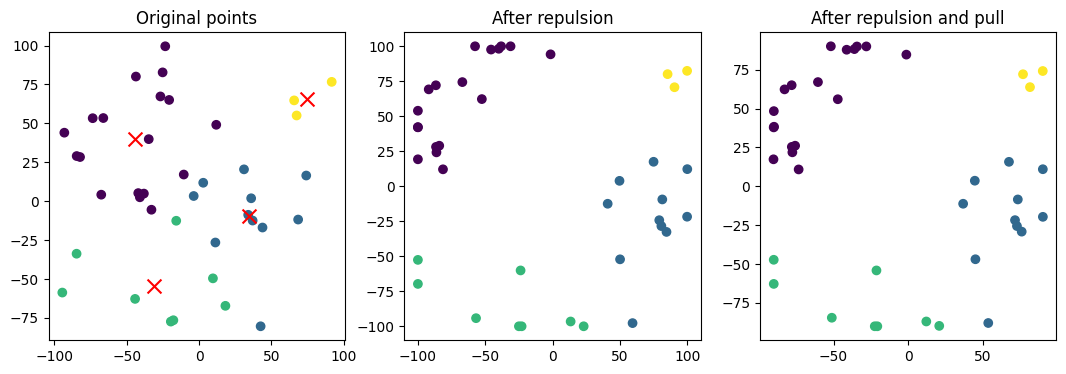

False
False


In [60]:
# Test hàm repulsion

# Tạo 40 điểm ngẫu nhiên trên không gian 2 chiều
np.random.seed(25)

points = np.random.uniform(-100, 100, (40, 2))

# Phân cụm các điểm
kmeans = KMeans(n_clusters=4)
kmeans.fit(points)

# Cập nhật các điểm trong cùng một cụm theo mô hình repulsion
new_points = points.copy()

for i in range(4):
    members = [j for j in range(40) if kmeans.labels_[j] == i]
    neighbors = [j for j in range(40) if kmeans.labels_[j] != i]

    for j in members:
        new_points[j] = repulsion(points[j], [points[k] for k in neighbors], 2)

# Thử bước làm mới tiếp theo, kéo các newpoints về gần điểm 0, trừ mỗi new_points cho một nhiễu Gaussian
final_points = new_points.copy()

for i in range(40):
    final_points[i] = final_points[i] * 0.9 + np.random.normal(0, 0.1, 2)

# Vẽ 3 đồ thị tương ứng (tâm cụm chữ x màu đỏ)
plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title("Original points")

plt.subplot(1, 3, 2)
plt.scatter(new_points[:, 0], new_points[:, 1], c=kmeans.labels_)
plt.title("After repulsion")

plt.subplot(1, 3, 3)
plt.scatter(final_points[:, 0], final_points[:, 1], c=kmeans.labels_)
plt.title("After repulsion and pull")

plt.show()

# Kiểm tra final_points có tọa độ nào trùng vào -100 hoặc 100 không
print(np.any(final_points == -100))
print(np.any(final_points == 100))

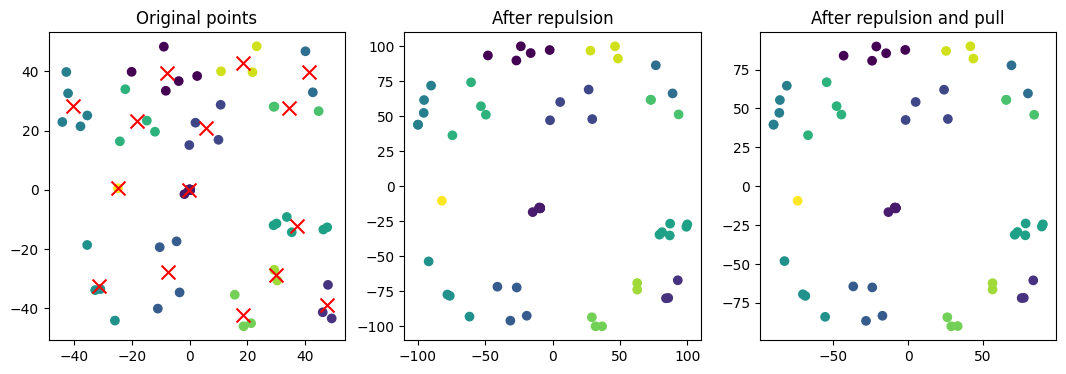

In [11]:
# Test hàm repulsion

# Khởi tạo 50 điểm theo phân phối đều trên hình vuông [-50, 50]
np.random.seed(2501)

points = np.random.uniform(-50, 50, (50, 2))

# Thêm 10 điểm [0, 0] vào tập điểm
points = np.vstack([points, np.zeros((10, 2))])

# Thêm nhiễu Gaussian vào các điểm
points = points + np.random.normal(0, 0.1, (60, 2))

# Phân cụm các điểm
kmeans = KMeans(n_clusters=15)
kmeans.fit(points)

# Cập nhật các điểm trong cùng một cụm theo mô hình repulsion
new_points = points.copy()

for i in range(15):
    members = [j for j in range(60) if kmeans.labels_[j] == i]
    neighbors = [j for j in range(60) if kmeans.labels_[j] != i]

    for j in members:
        new_points[j] = repulsion(points[j], [points[k] for k in neighbors], 2)

# Thử bước làm mới tiếp theo, kéo các newpoints về gần điểm 0, trừ mỗi new_points cho một nhiễu Gaussian
final_points = new_points.copy()

for i in range(60):
    final_points[i] = final_points[i] * 0.9 + np.random.normal(0, 0.1, 2)

# Vẽ 3 đồ thị tương ứng (tâm cụm chữ x màu đỏ)
plt.figure(figsize=(13, 4))

plt.subplot(1, 3, 1)
plt.scatter(points[:, 0], points[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title("Original points")

plt.subplot(1, 3, 2)
plt.scatter(new_points[:, 0], new_points[:, 1], c=kmeans.labels_)
plt.title("After repulsion")

plt.subplot(1, 3, 3)
plt.scatter(final_points[:, 0], final_points[:, 1], c=kmeans.labels_)
plt.title("After repulsion and pull")

plt.show()

In [59]:
for i in range(24):
    error, _, _ = run_CMAES_cc_v1(i, 
        fitness_wrapper, 
        gnbg_instances, 
        communication=communication_v1, 
        competition=competition_v3, 
        max_generation=3000, 
        seed=1, 
        use_tqdm=False
    )
    print(f"f{i + 1}: {error}")

f1: 0.0
f2: 0.0
f3: 3.410605131648481e-13
f4: 5.684341886080802e-14
f5: 0.2519952616032697
f6: 0.2658132554483075
f7: 0.0
f8: 0.0
f9: 78.0929364767552
f10: 0.0
f11: 0.0
f12: 0.0
f13: 28.030037506937617
f14: 0.8128079729557101
f15: 4.4990361704141435
f16: 9.094947017729282e-13
f17: 9.094947017729282e-13
f18: 0.0
f19: 0.0
f20: 0.0001582050984865191
f21: 5.000000000000007
f22: 58.522002935008345
f23: 2.5153212845907547e-12
f24: 15.836892233960924


In [10]:
for i in range(24):
    error, _, _ = run_CMAES_cc_v2(i, 
        fitness_wrapper, 
        gnbg_instances, 
        communication=communication_v1, 
        competition=competition_v3, 
        max_generation=3000, 
        seed=1, 
        use_tqdm=False
    )
    print(f"f{i + 1}: {error}")

f1: 0.0
f2: 0.03589682359370272
f3: 4.450801902448916
f4: 5.684341886080802e-14
f5: 1.194647864288072
f6: 1.0442382494603635
f7: 0.0
f8: 0.0
f9: 0.03820085470147205
f10: 0.0
f11: 0.0
f12: 0.0
f13: 0.6403805533679474
f14: 9.661902321478095
f15: 4.1011153250326515
f16: 0.0
f17: 532.1494594013229
f18: 0.0
f19: 529.6000000000004
f20: 1.7731035484302993e-07
f21: 5.000000000000007
f22: 50.0
f23: 1.071498445526231e-11
f24: 14.808369387884468


In [14]:
# Chạy cho hàm f5 trên 20 seed thống kê kết quả
errors = []

for seed in range(1, 21):
    error, _, _ = run_CMAES_cc_v1(4, 
        fitness_wrapper, 
        gnbg_instances, 
        communication=communication_v1, 
        competition=competition_v3, 
        max_generation=3000, 
        seed=seed, 
        use_tqdm=False
    )
    errors.append(error)

# Tính trung bình và độ lệch chuẩn
errors = np.array(errors)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean error: {mean_error}")
print(f"Standard deviation: {std_error}")

Mean error: 1.0725540381661887
Standard deviation: 0.34383135076714805


In [15]:
# Giá trị nhỏ nhất trong errors
min_error = np.min(errors)

min_error

0.072805150049021

In [17]:
# Chạy cho hàm f21 trên 20 seed thống kê kết quả
errors = []

for seed in range(1, 21):
    error, _, _ = run_CMAES_cc_v1(20, 
        fitness_wrapper, 
        gnbg_instances, 
        communication=communication_v1, 
        competition=competition_v3, 
        max_generation=5000, 
        seed=seed, 
        use_tqdm=False
    )
    errors.append(error)

# Tìm min 
min_error = np.min(errors)

min_error

5.000000000000007

### Communication V2: Success History + Adaptive Weighted Centroid

Giả sử có hệ $n$ điểm $\mathbf{x}_1,\mathbf{x}_2,\ldots,\mathbf{x}_n$ chia thành $k$ cụm $\mathcal{C}_1,\mathcal{C_2},\ldots,\mathcal{C}_k$ tương ứng có các trọng tâm $\mathbf{c}_1,\mathbf{c}_2,\ldots,\mathbf{c}_k$.

Hàm chỉ thị $\mathbb{I}\{E\}$ nhận giá trị $1$ nếu sự kiện $E$ xảy ra và nhận giá trị $0$ nếu sự kiện $E$ không xảy ra. Như vậy:
\begin{align*}
\mathbf{c}_i = \frac{1}{|\mathcal{C}_i|} \sum_{j=1}^n \mathbb{I}\{\mathbf{x}_j\in\mathcal{C}_i\} \mathbf{x}_j
\end{align*}


Trong công thức phiên bản 1, điểm $\mathbf{x}$ đạt được vị trí mới theo công thức:
\begin{align*}
\mathbf{x}_{\text{new}} = \mathbf{x} + v(\mathbf{x}) \times \left( \sum_{i=1}^k \mathbb{I}\{\mathbf{x}\in\mathcal{C}_i\}\mathbf{c}_i - \mathbf{x}\right) \quad \text{với} \quad 0\leq v(\mathbf{x}) = \frac{f(\mathbf{x}) - \min(\mathbf{x})}{\max(\mathbf{x})-\min(\mathbf{x})} \leq 1
\end{align*}

Trong đó:
\begin{align*}
\min(\mathbf{x}) = \min_{j = \overline{1,n}} \sum_{i=1}^k \mathbb{I}\{\mathbf{x},\mathbf{x}_j \in \mathcal{C}_i\}f(\mathbf{x}_j) \quad \text{và} \quad \max(\mathbf{x}) = \max_{j = \overline{1,n}} \sum_{i=1}^k \mathbb{I}\{\mathbf{x},\mathbf{x}_j \in \mathcal{C}_i\}f(\mathbf{x}_j) 
\end{align*}

Như vậy, một cách tổng quát, vị trí mới có cách cập nhật:
\begin{align*}
\mathbf{x}_{\text{new}} = \mathbf{x} + v(\mathbf{x}) \times \left( \frac{1}{|\mathcal{C}_i|} \sum_{i=1}^k \sum_{j=1}^n \mathbb{I}\{\mathbf{x},\mathbf{x}_j\in\mathcal{C}_i\}\mathbf{x}_j - \mathbf{x}\right)
\end{align*}

Ở đây, ta có $\frac{1}{|\mathcal{C}_i|} \sum_{i=1}^k \sum_{j=1}^n \mathbb{I}\{\mathbf{x},\mathbf{x}_j\in\mathcal{C}_i\} = 1$ với mọi $\mathbf{x}\in\{\mathbf{x}_1,\mathbf{x}_2,\ldots,\mathbf{x}_n\}$. Công thức này có thể tổng quát thành:
\begin{align*}
\mathbf{x}_{\text{new}} = \mathbf{x} + \left(\sum_{i=1}^k \sum_{j=1}^n w_{ij}\mathbf{x}_j - \mathbf{x}\right)
\end{align*}

Trong đó $0\leq w_{ij} \leq 1$ là trọng số biến đổi thỏa mãn $\sum_{i=1}^k \sum_{j=1}^n w_{ij} = 1 \ (*)$.

Trước hết ta thiết lập nên ma trận $\mathbf{W} = [w_{ij}] \in \mathbb{R}^{k \times n}$. Sau đó, chuẩn hóa theo tổng các phần tử của nó để thỏa mãn điều kiện $(*)$.

Kết hợp biểu diễn $\mathbf{X} = \begin{bmatrix} \mathbf{x}_1\\ \mathbf{x}_2 \\ \ldots \\ \mathbf{x}_n \end{bmatrix} \in \mathbb{R}^{n\times D}$ thì ta có:
\begin{align*}
\mathbf{W} \times \mathbf{X} = \begin{bmatrix} w_{11} & w_{12} & \ldots & w_{1n} \\ w_{21} & w_{22} & \ldots & w_{2n} \\ \ldots & \ldots & \ldots & \ldots \\ w_{k1} & w_{k2} & \ldots & w_{kn} \end{bmatrix} \times \begin{bmatrix} \mathbf{x}_1\\ \mathbf{x}_2 \\ \ldots \\ \mathbf{x}_n \end{bmatrix} = \begin{bmatrix} \sum_{j=1}^n w_{1j} \mathbf{x}_j \\ \sum_{j=1}^n w_{2j} \mathbf{x}_j \\ \ldots \\ \sum_{j=1}^n w_{kj} \mathbf{x}_j\end{bmatrix} \in \mathbb{R}^{k\times D}
\end{align*}

Như vậy, kí hiệu $\mathbf{1} = \underbrace{[1, 1, \ldots, 1]}_{k} \in \mathbb{R}^{1\times k}$ thì:
\begin{align*}
\sum_{i=1}^k \sum_{j=1}^n w_{ij}\mathbf{x}_j = \mathbf{1} \times \mathbf{W} \times \mathbf{X} \in \mathbb{R}^{1\times D}
\end{align*}

Công thức cập nhật viết lại là:
\begin{align*}
\mathbf{x}_{\text{new}} = \mathbf{x} + \left( \mathbf{1} \times \mathbf{W} \times \mathbf{X} - \mathbf{x}\right)
\end{align*}

Công thức xác định $w_{ij} = f(i,j)$ là hàm đồng biến theo độ tốt của $\mathbf{x}_j$ (càng tốt thì càng tiến về nhiều hơn), tỉ lệ nghịch với đa dạng của $\mathcal{C}_i$ (các cá thể phân phối xa nhau thì sức kéo càng mạnh), có xu hướng tiến về điểm tin cậy (trust point) đạt được thông qua Quá trình Gauss.

Ma trận giao tiếp $\mathbf{W}$ được cập nhật thông qua chiến lược tiến hóa:
\begin{align*}
\mathbf{W}^{t+1} = \lambda \mathbf{W}^t + (1-\lambda) \sum_{i=1}^{t-1} \mathbf{W}^i
\end{align*}


In [ ]:
# COMMUNICATION V2: 